CIFAR dataset includes subsets of 80 million labeled images. The dataset was removed from internet.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch

In [1]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def get_data(data_normalize=False, data_augment=False):

    train_transform = transforms.Compose([])
    test_transform = transforms.Compose([])

    if data_augment:
        train_transform.transforms.append(transforms.RandomCrop(32,padding=4))
        train_transform.transforms.append(transforms.RandomHorizontalFlip())

    train_transform.transforms.append(transforms.ToTensor())
    test_transform.transforms.append(transforms.ToTensor())

    if data_normalize:
        normalize = transforms.Normalize(
            mean = [x / 255.0 for x in [125.3, 123.0, 113.9]],
            std = [x / 255.0 for x in [63.0, 62.1, 66.7]],
        )
        train_transform.transforms.append(normalize)
        test_transform.transforms.append(normalize)

    train_dataset = datasets.CIFAR10(
        root="data/", train=True, transform=train_transform, download=True
    )

    test_dataset = datasets.CIFAR10(
        root="data/", train=False, transform=test_transform, download=True
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2
    )

    return train_loader, test_loader

In [13]:
def test(net, loader):
    # Change model to eval mode
    net.eval()
    correct = 0.0
    total=0.0

    for images, labels in loader:
        with torch.no_grad():
            pred = net(images)

        pred = torch.max(pred.data, 1)[1]

        total += labels.size(0)

        correct += (pred == labels).sum().item()

        val_acc = correct / total

        net.train()
        return val_acc

In [16]:
def train_model(train_loader, test_loader, epochs=5):

    # initialize internal model state
    net = Net()

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_accs = []
    test_accs = []

    net.train()

    for epoch in range(epochs):

        print(epoch)

        xentropy_loss_avg = 0.0

        correct = 0.0
        total = 0.0

        for i, (images, labels) in enumerate(train_loader):
            
            # Reset the gradients of all model parameters
            net.zero_grad()

            pred = net(images)

            xentropy_loss = criterion(pred, labels)
            xentropy_loss.backward()

            optimizer.step()

            xentropy_loss_avg += xentropy_loss.item()

            # Calculate running average of accuracy
            pred = torch.max(pred.data, 1)[1]
            total += labels.size(0)

            correct += (pred == labels.data).sum().item()
            accuracy = correct / total

        
        test_acc = test(net, test_loader)

        print(f"Test accuracy: {test_acc}")
        train_accs.append(accuracy)
        test_accs.append(test_acc)

    return train_accs, test_accs

In [17]:
train_loader, test_loader = get_data(data_augment=False, data_normalize=False)
train_accs, test_accs = train_model(train_loader, test_loader, epochs=3)

Files already downloaded and verified
Files already downloaded and verified
0
Test accuracy: 0.328125
1
Test accuracy: 0.3828125
2
Test accuracy: 0.3671875


In [18]:
train_loader, test_loader = get_data(data_augment=False, data_normalize=True)
normalize_train_accs, normalize_test_accs = train_model(train_loader, test_loader, epochs=3)

Files already downloaded and verified
Files already downloaded and verified
0
Test accuracy: 0.4140625
1
Test accuracy: 0.421875
2
Test accuracy: 0.3828125


/var/folders/b9/_z9w0pmj70xgdmsd5b0p7l4w0000gn/T/ipykernel_23689/2779327151.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


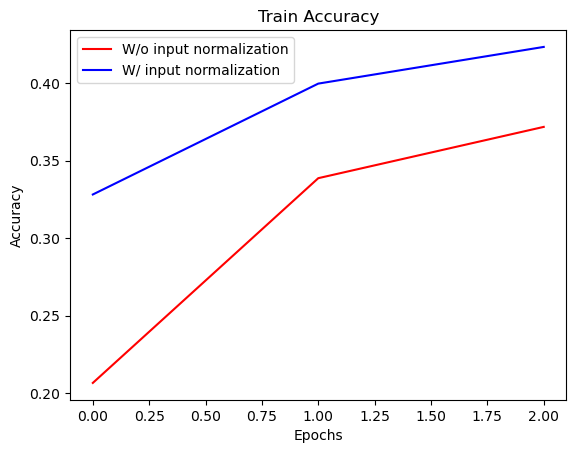

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
epochs = 3
ax.plot(range(epochs), train_accs, c="red", label="W/o input normalization")
ax.plot(range(epochs), normalize_train_accs, c="blue", label="W/ input normalization")

ax.legend()

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Train Accuracy")
fig.show()